## [psmpy package introduction](https://pypi.org/project/psmpy/)

## 1. Load packages

In [1]:
import numpy as np
import pandas as pd
# !pip install pingouin
import pingouin as pg # new
import statsmodels.api as sm # new
import matplotlib.pyplot as plt
import seaborn as sns
import math
# sns.set()  # set the style

In [2]:
def ttest_df(df, treatment_colname='treatment', cols=[]): # default for every describe-able columns
    
    df_control=df[df[treatment_colname]==0]
    df_treatment=df[df[treatment_colname]==1]
    
    df_=[]
    
    if cols==[]: iteration_list=df.describe().columns
    else: iteration_list=cols
        
    for col in iteration_list:
        
        # skip ttest for 'treatment' col
        if col == treatment_colname: continue

        # ttest
        row_=pg.ttest(df_control[col], df_treatment[col], confidence = 0.95)
        row_.index=[col]
        row_['control_mean']=df_control[col].mean()
        row_['treatment_mean']=df_treatment[col].mean()

        # cumulate
        df_.append(row_)

    return pd.concat(df_, axis=0)

In [3]:
# !pip install psmpy
from psmpy import PsmPy
from psmpy.plotting import *

## 2. Import Data
### [Download data from Kaggle](https://www.kaggle.com/datasets/harrywang/propensity-score-matching/)


In [4]:
df=pd.read_csv('./data/groupon.csv')
df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500


### 2.1. \[Before Match\] ttest

In [5]:
ttest_df(df)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,control_mean,treatment_mean
min_req,-8.162702,215.000000,two-sided,2.745901e-14,"[-31.66, -19.35]",1.007870,3.451e+12,1.000000,1.000000,26.504630
prom_length,4.025108,410.004143,two-sided,6.783574e-05,"[0.22, 0.64]",0.328313,229.654,0.980273,3.809717,3.379630
price,3.045062,475.606453,two-sided,2.455391e-03,"[3.0, 13.9]",0.233573,8.199,0.815825,37.870445,29.421296
discount_pct,-0.475765,512.993585,two-sided,6.344441e-01,"[-1.49, 0.91]",0.035411,0.101,0.071794,52.973684,53.263889
coupon_duration,-3.470679,412.676547,two-sided,5.738903e-04,"[-56.24, -15.57]",0.282300,31.222,0.932686,95.941296,131.842593
featured,-1.385150,364.919741,two-sided,1.668528e-01,"[-0.09, 0.02]",0.119074,0.232,0.308082,0.105263,0.143519
limited_supply,2.287379,357.599186,two-sided,2.275718e-02,"[0.01, 0.14]",0.198547,1.16,0.681098,0.852227,0.777778
fb_likes,-2.610152,330.098346,two-sided,9.462677e-03,"[-61.84, -8.69]",0.235855,2.496,0.823168,77.941296,113.203704
quantity_sold,-2.847712,307.118783,two-sided,4.700377e-03,"[-298.2, -54.5]",0.267669,4.674,0.906078,333.002024,509.351852
revenue,-1.729643,292.034758,two-sided,8.475071e-02,"[-6477.14, 417.73]",0.167476,0.391,0.536033,9720.987854,12750.694444


### 2.2. Calculate Propensity Scores

In [6]:
# choose features for propensity score calculation
X = df[['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'limited_supply']]
## hence @3. Matching Procedure, exclude=['min_req', 'start_date', 'fb_likes', 'quantity_sold', 'revenue']
y = df['treatment']

X.head()

,prom_length,price,discount_pct,coupon_duration,featured,limited_supply
0,4,99,51,185,1,1
1,2,95,41,9,0,1
2,3,25,50,38,0,1
3,3,50,50,369,0,1
4,4,25,52,185,0,1


In [7]:
# use logistic regression to calculate the propensity scores
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

In [8]:
# get the coefficients
coeffs=pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel().round(4),
    'p_value': sm.OLS(y, sm.add_constant(X)).fit().pvalues.drop(['const'])
})
coeffs

,column,coeff,p_value
prom_length,prom_length,-0.3284,0.000010
price,price,-0.0086,0.008066
discount_pct,discount_pct,-0.0079,0.527169
coupon_duration,coupon_duration,0.0035,0.000018
featured,featured,0.3080,0.209979
limited_supply,limited_supply,-0.3665,0.040335


In [9]:
# prediction
pred_binary=lr.predict(X)
pred_prob=lr.predict_proba(X)

id=17
print('the binary prediction is:', pred_binary[17])
print('the corresponding probabilities are:', pred_prob[17].round(4))

the binary prediction is: 1
the corresponding probabilities are: [0.3963 0.6037]


In [10]:
# the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
df['ps'] = pred_prob[:, 1]

# calculate the logit of the propensity score for matching if needed
df['ps_logit'] = df.ps.apply(lambda p: math.log(p / (1-p))) # logit

df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps,ps_logit
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460,0.259193,-1.050170
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050,0.230198,-1.207194
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500,0.288405,-0.903144
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500,0.511781,0.047131
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500,0.325212,-0.729919


### 2.3. Overlap Condition

<AxesSubplot:xlabel='ps', ylabel='Count'>

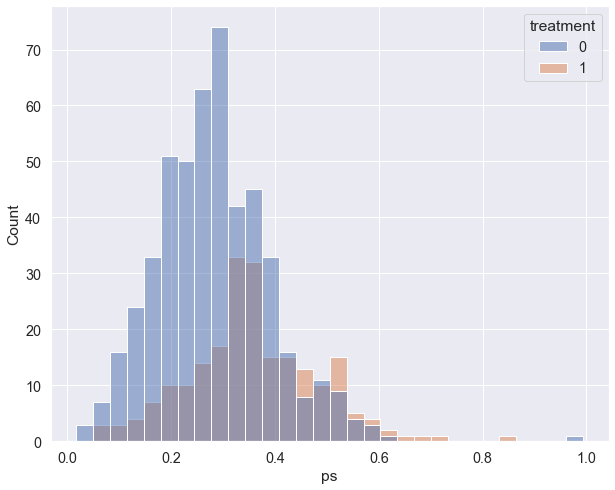

In [11]:
# check the overlap of ps for control and treatment using histogram
# if there is not much overlap, the matching won't work
sns.histplot(data=df, x='ps', hue='treatment')  # multiple="dodge" for 

## 3. Matching Procedure

In [12]:
# again, import data
df=pd.read_csv('./data/groupon.csv')
df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500


In [13]:
# exclude: ignore any covariates (columns) passed to the it during model fitting
# indx - required parameter that references a unique ID number for each case
psm=PsmPy(df, treatment='treatment', indx='deal_id',
          exclude=['min_req', 'start_date', 'fb_likes', 'quantity_sold', 'revenue'])

**balance** - Whether the logistic regression will run in a balanced fashion, default = True. [REF](https://pypi.org/project/psmpy/#predict-scores)

There often exists a significant Class Imbalance in the data. This will be detected automatically in the software where the majority group has more records than the minority group. We account for this by setting balance=True when calling psm.logistic_ps(). This tells PsmPy to sample from the majority group when fitting the logistic regression model so that the groups are of equal size. This process is repeated until all the entries of the major class have been regressed on the minor class in equal paritions. This calculates both the logistic propensity scores and logits for each entry.

In [14]:
psm.logistic_ps(balance=True) # balance: whether the logistic regression will run in a balanced fashion, default=True.
psm.predicted_data

,deal_id,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,propensity_score,propensity_logit,treatment
0,heli-flights,4,99,51,185,1,1,0.536882,0.147795,1
1,gl-champion-series-tennis-electric-factory,2,95,41,9,0,1,0.405332,-0.383296,1
2,realm-of-terror-horror-experience,3,25,50,38,0,1,0.521260,0.085091,1
3,newport-gourmet,3,50,50,369,0,1,0.609596,0.445615,1
4,the-clayroom,4,25,52,185,0,1,0.532237,0.129128,1
...,...,...,...,...,...,...,...,...,...,...
705,whitewater-challengers-9,5,45,54,164,0,1,0.317059,-0.767320,0
706,world-domination-events,8,149,67,52,0,1,0.015352,-4.161068,0
707,xtreme-xperience-chicago,4,159,60,29,0,1,0.038281,-3.223755,0
708,your-neighborhood-theatre,4,19,51,187,0,1,0.549241,0.197606,0


In [15]:
psm.knn_matched(matcher='propensity_score', replacement=False, caliper=None)

C:\Users\2joon\anaconda3\lib\site-packages\psmpy\psmpy.py:346: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')


## 4. Checkout Results

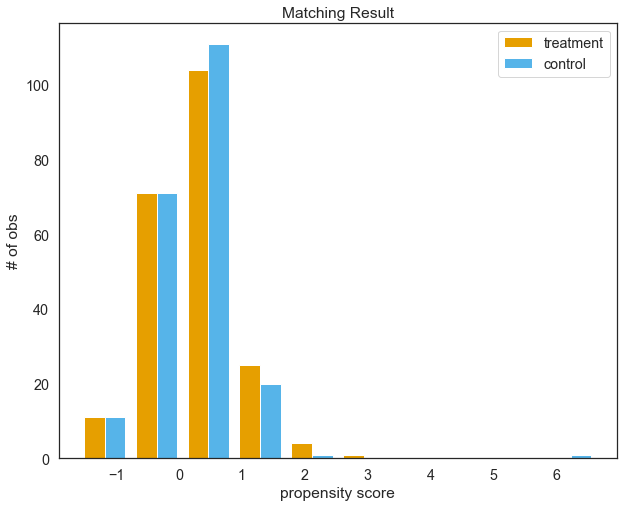

In [16]:
psm.plot_match(Title='Matching Result',
               Ylabel='# of obs',
               Xlabel='propensity score',
               names=['treatment', 'control'])

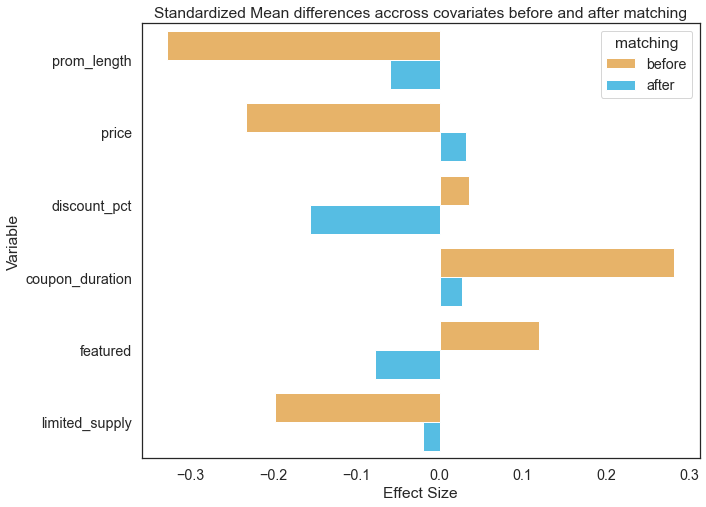

In [17]:
psm.effect_size_plot()

In [18]:
# psm.effect_size
psm.effect_size.set_index(['Variable', 'matching'])

Effect Size
Variable        matching             
prom_length     before      -0.328313
                after       -0.059402
price           before      -0.233573
                after        0.031998
discount_pct    before       0.035411
                after       -0.156675
coupon_duration before       0.282300
                after        0.027145
featured        before       0.119074
                after       -0.078266
limited_supply  before      -0.198547
                after       -0.019978

In [19]:
psm.matched_ids

,deal_id,matched_ID
0,heli-flights,gl-ogunquit-playhouse-1
1,gl-champion-series-tennis-electric-factory,gl-brockton-rox
2,realm-of-terror-horror-experience,penobscot-adventures-3
3,newport-gourmet,kew-gardens-cinemas
4,the-clayroom,affairs-afloat-2
...,...,...
211,gl-windy-city-circus-1,hampton-beach-parasail-and-jet-ski
212,lets-go-paragliding,dc-brd-chicago-savvy-tours
213,spare-time-chicago-3,paper-crown-gallery
214,dc-gmt-slice-chicago-tours,team-combat-live


In [20]:
# psm.df_matched
df_matched=pd.merge(psm.df_matched, df[['deal_id', 'fb_likes', 'quantity_sold', 'revenue']], on='deal_id', how='left')
df_matched

,deal_id,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,propensity_score,propensity_logit,treatment,fb_likes,quantity_sold,revenue
0,heli-flights,4,99,51,185,1,1,0.536882,0.147795,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,2,95,41,9,0,1,0.405332,-0.383296,1,43,190,18050
2,realm-of-terror-horror-experience,3,25,50,38,0,1,0.521260,0.085091,1,208,380,9500
3,newport-gourmet,3,50,50,369,0,1,0.609596,0.445615,1,16,90,4500
4,the-clayroom,4,25,52,185,0,1,0.532237,0.129128,1,85,580,14500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,hampton-beach-parasail-and-jet-ski,5,59,53,108,0,1,0.347354,-0.630690,0,61,170,10030
427,dc-brd-chicago-savvy-tours,7,12,52,108,0,1,0.202765,-1.369102,0,57,1000,12000
428,paper-crown-gallery,3,30,65,158,0,1,0.535865,0.143707,0,25,90,2700
429,team-combat-live,3,79,51,122,0,1,0.254645,-1.073991,0,32,30,2370


### 4.1. \[After Match\] ttest

In [21]:
ttest_df(df_matched)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,control_mean,treatment_mean
prom_length,0.616874,415.674183,two-sided,0.537656,"[-0.16, 0.3]",0.059402,0.128,0.094365,3.451163,3.379630
price,-0.332402,388.412827,two-sided,0.739765,"[-6.19, 4.4]",0.031998,0.113,0.062674,28.525581,29.421296
discount_pct,1.625230,395.065368,two-sided,0.104911,"[-0.27, 2.82]",0.156675,0.382,0.368122,54.539535,53.263889
coupon_duration,-0.281632,409.302417,two-sided,0.778368,"[-30.92, 23.17]",0.027145,0.111,0.059103,127.967442,131.842593
featured,0.812279,426.383554,two-sided,0.417085,"[-0.04, 0.1]",0.078266,0.147,0.128001,0.172093,0.143519
limited_supply,0.207382,428.965180,two-sided,0.835810,"[-0.07, 0.09]",0.019978,0.109,0.054919,0.786047,0.777778
propensity_score,-1.187037,426.825731,two-sided,0.235873,"[-0.04, 0.01]",0.114335,0.211,0.219769,0.541930,0.557285
propensity_logit,-0.850080,424.687913,two-sided,0.395760,"[-0.18, 0.07]",0.081912,0.151,0.135646,0.198286,0.253445
fb_likes,-2.591954,350.235966,two-sided,0.009943,"[-63.94, -8.77]",0.249423,2.704,0.733462,76.851163,113.203704
quantity_sold,-1.350536,406.683810,two-sided,0.177595,"[-237.81, 44.12]",0.130034,0.258,0.270344,412.506977,509.351852
